# Analyze`TedSim` grid-search results (w/ replicates) 

Application of `moslin` on `TedSim` simulations [[PHX-22]](https://doi.org/10.1093/nar/gkac235).


# Preliminaries

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import utils_run
from utils_analysis import state_tree_draw, tree_draw, plot_cost, node_colors

import glob

import moscot as mc

In [3]:
mc.__version__

'0.3.4.dev158+gee31deb'

In [4]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Dependencies

Run `data_generation` and `experiments` according to the instructions in the README

## Set up paths

Define the paths for data and figures

In [5]:
sys.path.insert(
    0, "../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "simulations/pan_tedsim"
DATA_DIR = DATA_DIR / "simulations/pan_tedsim"
LOG_DIR = DATA_DIR / "simulations/pan_tedsim"

## Set global parameters

In [6]:
import mplscience

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["figure.dpi"] = 300

# Visualize Tedsim simulation


We can visualize the state tree the cells were sampled from

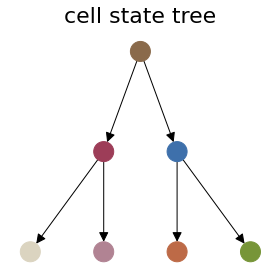

In [7]:
state_tree_draw(state_tree="((t1:2, t2:2):1, (t3:2, t4:2):1):2;", path=str(FIG_DIR))

And the actual simulated tree.<br>
For the purpose of visualizations we focus only the early tree (up to depth 8 in the simulation).

In [8]:
from utils_analysis import _build_true_trees, _is_leaf
import utils_run
import lineageot.inference as lot_inf

Only considering the two last: ['.4_12102', '.h5ad'].
Only considering the two last: ['.4_12102', '.h5ad'].


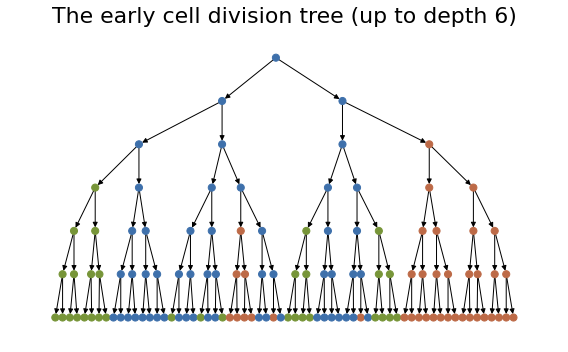

In [9]:
adata = sc.read(DATA_DIR / "adata_0.4_0.4_12102.h5ad")
tree_draw(adata, depth=6, path=str(FIG_DIR))

We can see that cell"s state obeys underlying cell state tree. <br>
For each cell the descendants are either of the same state or of a valid descendant based on the cell state tree.

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

In [11]:
adata.uns["cluster_colors"] = [
    node_colors[c] for c in adata.obs["cluster"].cat.categories
]

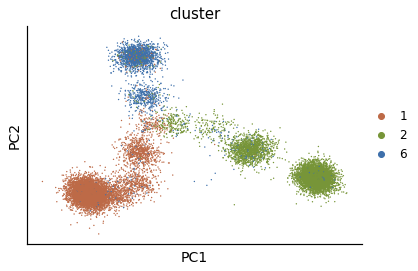

In [12]:
sc.pl.pca(adata[adata.obs["cluster"].isin([1, 2, 6])], color="cluster", show=False)
plt.savefig(
    FIG_DIR / "cluster_graph.png", bbox_inches="tight", transparent=True, dpi=300
)
plt.show()

# Import grid results

In [13]:
filenames = glob.glob("/cs/labs/mornitzan/zoe.piran/research/projects/moslin_analysis_2/data/simulations/pan_tedsim_rev/output/*.csv")
filenames_res = [file for file in filenames if "cluster" not in file]
filenames_clust = [file for file in filenames if "cluster" in file]
filenames_clust = [file for file in filenames_clust if "gt" not in file]
filenames_clust_gt = [file for file in filenames_clust if "gt" in file]

In [14]:
res = None
for file in filenames_res:
    dfc = pd.read_csv(file)
    if res is None:
        res = dfc
    else:
        res = pd.concat([res, dfc], ignore_index=True)

In [15]:
res_clust = None
for file in filenames_clust:
    dfc = pd.read_csv(file)
    dfc["kind"] = dfc["kind"].str.strip("['']")
    dfc["cluster_transient"] = dfc["cluster_transient"].str.strip("[]")
    dfc["cluster_transient"] = [eval(b) for b in dfc["cluster_transient"]]
    dfc["kind_cluster"] = dfc["kind"]
    dfc.loc[dfc["cluster_transient"], "kind_cluster"] = dfc["kind"] + " (emergent)"
    dfc["cluster"] = dfc["cluster"].str.strip("[]").astype(int) 
    dfc["p_a"] = 0.4
    dfc["ss"] = 0.4
    dfc["ssr"] = float(file.split("/")[-1].split("_")[3])
    dfc["data_seed"] = int(file.split("/")[-1].split("_")[2])
    dfc["scale_cost"] = "mean"
    dfc["depth"] = 8
    
    for col in ["alpha", "epsilon", "non_zero", "diff"]:
        dfc[col] = dfc[col].str.strip("[]")
        dfc[col] = [np.nan if a=="None" else float(a) for a in dfc[col].values]
    if "gt" in file:
        continue
    if res_clust is None:
        res_clust = dfc
    else:
        res_clust = pd.concat([res_clust, dfc], ignore_index=True)

In [16]:
res["mean_cost"] = (res["early_cost"] + res["late_cost"]) / 2
res = res.drop(columns="Unnamed: 0")

In [17]:
res_clust = res_clust.drop(columns="Unnamed: 0")

In [18]:
for df in [res, res_clust]:
    df.loc[df["alpha"] == 0.0, "kind"] = "OT"
    df.loc[df["alpha"] == 1.0, "kind"] = "GW"

In [19]:
res.loc[res["tree_type"] == "fitted-tree","kind"] = res["kind"] + " (fitted-tree)"
res.loc[res["tree_type"] == "ground-truth","kind"] =  res["kind"] + " (ground-truth)"
res.loc[res["tree_type"] == "state-only","kind"] = res["kind"] + " (state-only)"

In [20]:
idx = (
    res.groupby(
        ["p_a", "ssr", "ss", "kind", "data_seed"]
    )["mean_cost"].transform(min)
    == res["mean_cost"]
)
df_min = res[idx]

In [21]:
idx = (
    res.groupby(
        ["p_a", "ssr", "ss", "kind", "data_seed", "alpha"]
    )["mean_cost"].transform(min)
    == res["mean_cost"]
)
df_min_epsilon = res[idx]

In [22]:
res_clust[(res_clust["ssr"] == 0) & (res_clust["kind"] == "moslin") ]

,kind,alpha,epsilon,cluster,cluster_transient,non_zero,diff,kind_cluster,p_a,ss,ssr,data_seed,scale_cost,depth
486,moslin,0.100,0.0001,1,False,0.977612,68.131288,moslin,0.4,0.4,0.0,12102,mean,8
487,moslin,0.100,0.0001,2,False,0.979406,75.407632,moslin,0.4,0.4,0.0,12102,mean,8
488,moslin,0.100,0.0001,3,False,0.769663,84.578652,moslin,0.4,0.4,0.0,12102,mean,8
489,moslin,0.100,0.0001,4,False,0.851240,89.793388,moslin,0.4,0.4,0.0,12102,mean,8
490,moslin,0.100,0.0001,6,False,0.960479,79.962874,moslin,0.4,0.4,0.0,12102,mean,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9029,moslin,0.999,0.1000,2,False,0.990445,48.190931,moslin,0.4,0.4,0.0,23860,mean,8
9030,moslin,0.999,0.1000,3,False,0.980000,16.540000,moslin,0.4,0.4,0.0,23860,mean,8
9031,moslin,0.999,0.1000,4,False,0.916667,30.129630,moslin,0.4,0.4,0.0,23860,mean,8
9032,moslin,0.999,0.1000,6,False,0.956113,32.783699,moslin,0.4,0.4,0.0,23860,mean,8


In [23]:
res_clust_min = None
for kind in res_clust["kind"].unique():
    print(f"kind: {kind}")
    for data_seed in res_clust["data_seed"].unique():
        for ssr in res_clust["ssr"].unique():
            dfc = df_min[
                (df_min["kind"] == kind)
                & (df_min["data_seed"] == data_seed)
                & (df_min["ssr"] == ssr) 
            ]
            if dfc.shape[0] < 1:
                continue
            if kind in ["CoSpar", "CoSpar (fitted-tree)"]:
                dfc_clust = res_clust[
                    (res_clust["kind"] == kind) 
                    & (res_clust["data_seed"] == data_seed)
                    & (res_clust["ssr"] == ssr) 
                ]
            elif kind == "LineageOT":
                dfc_clust = res_clust[
                    (res_clust["kind"] == kind) 
                    & (res_clust["data_seed"] == data_seed)
                    & (res_clust["ssr"] == ssr) 
                    & (res_clust["epsilon"] == dfc["epsilon"].values[0])
                ]
            else:
                dfc_clust = res_clust[
                    (res_clust["kind"] == kind) 
                    & (res_clust["data_seed"] == data_seed)
                    & (res_clust["ssr"] == ssr) 
                    & (res_clust["epsilon"] == dfc["epsilon"].values[0])
                    & (res_clust["alpha"] == dfc["alpha"].values[0])
                ]
            if res_clust_min is None:
                res_clust_min = dfc_clust
            else:
                res_clust_min = pd.concat([res_clust_min, dfc_clust], ignore_index=True)

kind: OT
kind: moslin
kind: GW
kind: CoSpar
kind: CoSpar (fitted-tree)
kind: LineageOT


In [24]:
res_clust_min["mapping_acc"] = 1-res_clust_min["non_zero"]

# Plot Res

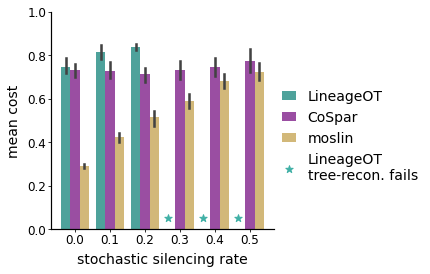

In [25]:
p_a = 0.4
step_size = 0.4
df_min_ss = df_min[df_min["ss"] == step_size]
ssrs = np.sort(df_min_ss["ssr"].unique())
hue_order = ["LineageOT", "CoSpar", "moslin"]
method_colors = {
    "moslin": "#E1BE6A",
    "CoSpar": "#A640B0",
    "LineageOT": "#40B0A6",
}

fontsize = 14

rows = 1
cols = len(ssrs)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

colors = {method: method_colors[method] for method in hue_order}
ax = sns.barplot(
    x="ssr",
    y="mean_cost",
    hue="kind",
    hue_order=hue_order,
    data=df_min_ss,
    ax=axs,
    palette=colors,
)


plt.scatter(
    x=[2.65, 3.65, 4.65], #[2.75, 3.78],
    y=[0.05, 0.05, 0.05],
    marker="*",
    s=60,
    label="LineageOT\ntree-recon. fails",
    color=colors["LineageOT"],
)


ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel("stochastic silencing rate")
ax.set_ylabel("mean cost", fontsize=fontsize)
ax.set_ylim(0, 1)
ax.legend(
    ncol=1,
    handlelength=1,
    fontsize=fontsize,
    # labelspacing=0.1,
    columnspacing=1,
    loc="upper right",
    bbox_to_anchor=(1.2, 0.2, 0.5, 0.5),
)

# plt.savefig(
#     FIG_DIR / 
#     "ssr_ss0.4_pa0.4_depth_8.pdf", bbox_inches="tight", dpi=300, format="pdf"
# )

plt.show()

In [26]:
df_min_stats = df_min_ss.drop(columns=['alpha', 'epsilon', 'p_a', 'ss', 'tree_type', 'seed', 'converged', 'early_cost', 'late_cost'])
mean_res = df_min_stats.groupby(["ssr", "kind"])["mean_cost"].mean()
std_res = df_min_stats.groupby(["ssr", "kind"])["mean_cost"].std()

In [27]:
mean_res_cmp = mean_res.reset_index()
mean_res_cmp["mean_diff"] = 0
for ssr in mean_res_cmp["ssr"].unique():
    mean_res_cmp.loc[mean_res_cmp["ssr"]==ssr ,"mean_diff"] = mean_res_cmp[mean_res_cmp["ssr"]==ssr]["mean_cost"].values - mean_res_cmp[(mean_res_cmp["ssr"]==ssr) & (mean_res_cmp["kind"]=="moslin")]["mean_cost"].values[0]

mean_res_cmp

,ssr,kind,mean_cost,mean_diff
0,0.0,CoSpar,0.731074,0.440241
1,0.0,CoSpar (fitted-tree),0.730770,0.439938
2,0.0,CoSpar (ground-truth),0.731070,0.440238
3,0.0,CoSpar (state-only),0.733249,0.442417
4,0.0,GW,0.352449,0.061617
5,0.0,LineageOT,0.747161,0.456329
6,0.0,OT,0.768234,0.477402
7,0.0,moslin,0.290832,0.000000
8,0.1,CoSpar,0.729058,0.304430
9,0.1,CoSpar (fitted-tree),0.725766,0.301139


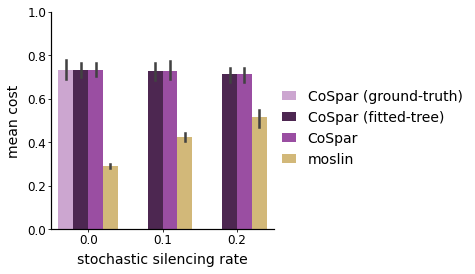

In [28]:
p_a = 0.4
step_sizep_a = 0.4
step_size = 0.4
df_min_ss = df_min[df_min["ss"] == step_size]
df_min_ss = df_min_ss[df_min_ss["ssr"].isin([0. , 0.1, 0.2])]
ssrs = np.sort(df_min_ss["ssr"].unique())
hue_order = [ 'CoSpar (ground-truth)','CoSpar (fitted-tree)','CoSpar', 'moslin']
method_colors = {
    "moslin": "#E1BE6A",
    "LineageOT": "#40B0A6",
    "CoSpar": "#A640B0",
    "CoSpar (fitted-tree)": "#532058",
    "CoSpar (state-only)": "#d29fd7",
    "CoSpar (ground-truth)": "#d29fd7" #"#311334",
}

fontsize = 14

rows = 1
cols = len(ssrs)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

colors = {method: method_colors[method] for method in hue_order}
ax = sns.barplot(
    x="ssr",
    y="mean_cost",
    hue="kind",
    hue_order=hue_order,
    data=df_min_ss,
    ax=axs,
    palette=colors,
)


ax.set_xticklabels(ax.get_xticklabels()) 
ax.set_xlabel("stochastic silencing rate")
ax.set_ylabel("mean cost", fontsize=fontsize)
ax.set_ylim(0, 1)
ax.legend(
    ncol=1,
    handlelength=1,
    fontsize=fontsize,
    # labelspacing=0.1,
    columnspacing=1,
    loc="upper right",
    bbox_to_anchor=(1.4, 0.2, 0.5, 0.5),
)

# plt.savefig(
#     FIG_DIR / 
#     "ssr_ss0.4_pa0.4_depth8_cospar_supp.pdf", bbox_inches="tight", dpi=300, format="pdf"
# )

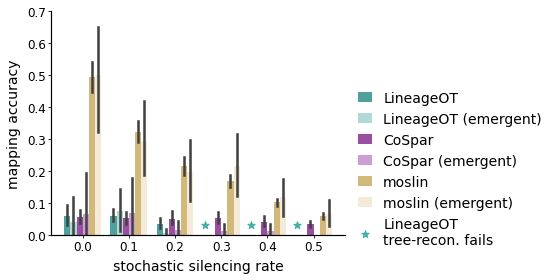

In [29]:
p_a = 0.4
step_size = 0.4
ssrs = np.sort(df_min_ss["ssr"].unique())
hue_order = ["LineageOT", "LineageOT (emergent)", "CoSpar", "CoSpar (emergent)", "moslin", "moslin (emergent)"]
method_colors = {
    "moslin": "#E1BE6A",
    "moslin (emergent)": "#f7ecd4",
    "CoSpar": "#A640B0",
    "CoSpar (emergent)": "#d396d9",
    "LineageOT": "#40B0A6",
    "LineageOT (emergent)": "#a9e0db",
}

fontsize = 14

rows = 1
cols = len(ssrs)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

colors = {method: method_colors[method] for method in hue_order}

ax = sns.barplot(
        x="ssr",
        y="mapping_acc",
        hue="kind_cluster",
        hue_order=hue_order,
        data=res_clust_min,
        ax=axs,
        palette=colors,
    )
    
axs.scatter(
        x=[2.65, 3.65, 4.65], #[2.75, 3.78],
        y=[0.03, 0.03, 0.03],
        marker="*",
        s=60,
        label="LineageOT\ntree-recon. fails",
        color=colors["LineageOT"],
    )
    
    
axs.set_xticklabels(axs.get_xticklabels())
axs.set_xlabel("stochastic silencing rate")
axs.set_ylim(0, 0.7)
    
axs.set_ylabel(f"mapping accuracy", fontsize=fontsize)
axs.legend(
        ncol=1,
        handlelength=1,
        fontsize=fontsize,
        # labelspacing=0.1,
        # columnspacing=1,
        # loc="upper right",
        bbox_to_anchor=(1, 0.2, 0.5, 0.5),
    )

plt.tight_layout()
plt.savefig(
    FIG_DIR / 
        "ssr_ss0.4_pa0.4_depth_8_cluster_transient_single.pdf", bbox_inches="tight", dpi=300, format="pdf"
)

plt.show()

# References


[[PHX-22] Pan, X., Li, H., & Zhang, X. (2022). TedSim: temporal dynamics simulation of single-cell RNA sequencing data and cell division history. Nucleic Acids Research, 50(8), 4272-4288.](https://doi.org/10.1093/nar/gkac235)